# Import Libs

In [1]:
import polars as pl
import polars.selectors as cs
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.model_selection import train_test_split

from collections import Counter

# Import Annotations

In [2]:
anno_1 = pl.read_csv("../../data/DEAM/static_annotations_averaged_songs_1_2000.csv")
anno_1 = anno_1.rename({col: col.strip() for col in anno_1.columns})

anno_2 = pl.read_csv("../../data/DEAM/static_annotations_averaged_songs_2000_2058.csv")
anno_2 = anno_2.rename({col: col.strip() for col in anno_2.columns})

anno_1.shape, anno_2.shape

((1744, 5), (58, 13))

In [3]:
display(anno_1, anno_2)

song_id,valence_mean,valence_std,arousal_mean,arousal_std
i64,f64,f64,f64,f64
2,3.1,0.94,3.0,0.63
3,3.5,1.75,3.3,1.62
4,5.7,1.42,5.5,1.63
5,4.4,2.01,5.3,1.85
7,5.8,1.47,6.4,1.69
…,…,…,…,…
1996,3.9,1.87,5.9,2.21
1997,5.3,1.42,3.9,1.14
1998,6.4,1.5,6.2,1.6


song_id,valence_mean,valence_std,valence_ max_mean,valence_max_std,valence_min_mean,valence_min_std,arousal_mean,arousal_std,arousal_max_mean,arousal_max_std,arousal_min_mean,arousal_min_std
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001,3.2,0.98,5.0,1.41,2.2,0.98,6.6,0.8,8.6,0.49,3.4,1.02
2002,6.4,0.49,8.2,0.98,5.0,1.1,5.2,1.17,7.4,1.36,2.2,1.17
2003,5.4,1.5,7.2,1.17,3.4,1.02,4.6,1.85,6.2,2.04,1.4,0.49
2004,5.0,1.1,6.4,1.02,3.2,1.17,4.8,1.6,6.0,2.28,2.8,0.98
2005,3.8,1.17,5.0,1.1,1.6,0.8,5.2,0.75,8.4,0.8,2.0,1.1
…,…,…,…,…,…,…,…,…,…,…,…,…
2054,5.4,1.2,6.0,1.1,4.4,1.36,3.6,1.36,4.2,1.33,2.4,0.8
2055,5.0,1.41,6.0,1.41,4.2,1.33,5.2,1.47,6.4,1.62,4.0,1.41
2056,5.0,1.41,5.6,1.62,4.4,1.36,4.6,1.74,5.0,1.79,4.0,1.67


In [4]:
all_annotations = pl.concat(
    [
        anno_1,
        anno_2.select(
            "song_id", "valence_mean", "valence_std", "arousal_mean", "arousal_std"
        ),
    ],
    how="vertical",
)


# Import Metadata

In [5]:
metadata_2013 = pl.read_csv("../../data/DEAM/metadata_2013.csv")
metadata_2014 = pl.read_csv(
    "../../data/DEAM/metadata_2014.csv", truncate_ragged_lines=True
)
metadata_2015 = pl.read_csv(
    "../../data/DEAM/metadata_2015.csv", truncate_ragged_lines=True
)

In [6]:
metadata_2013 = (
    metadata_2013.select("song_id", "Artist", "Song title", "Genre")
    .rename({"Artist": "artist", "Song title": "song_title", "Genre": "genre"})
    .with_columns(
        pl.col(pl.Utf8)
        .str.replace_all("\u00a0", " ")  # normalize non-breaking spaces if present
        .str.strip_chars()  # strip whitespace (space, tab, newline, etc.)
        .str.strip_chars('"')  # then strip leading/trailing double quotes
    )
)

In [7]:
metadata_2014 = (
    metadata_2014.select("Id", "Artist", "Track", "Genre")
    .rename(
        {
            "Id": "song_id",
            "Artist": "artist",
            "Track": "song_title",
            "Genre": "genre",
        }
    )
    .with_columns(
        pl.col(pl.Utf8)
        .str.replace_all("\u00a0", " ")  # normalize non-breaking spaces if present
        .str.strip_chars()  # strip whitespace (space, tab, newline, etc.)
        .str.strip_chars('"')  # then strip leading/trailing double quotes
    )
)

In [8]:
metadata_2015 = (
    metadata_2015.select("id", "artist", "title", "genre")
    .rename(
        {
            "id": "song_id",
            "title": "song_title",
        }
    )
    .with_columns(
        pl.col(pl.Utf8)
        .str.replace_all("\u00a0", " ")  # normalize non-breaking spaces if present
        .str.strip_chars()  # strip whitespace (space, tab, newline, etc.)
        .str.strip_chars('"')  # then strip leading/trailing double quotes
    )
)

In [9]:
all_metadata = pl.concat(
    [metadata_2013, metadata_2014, metadata_2015],
    how="vertical",
)

# Join Annotations & Metadata

In [10]:
annot_meta = all_annotations.join(all_metadata, on="song_id", how="left").with_columns(
    pl.col("genre").str.to_lowercase().alias("genre")
)
annot_meta

song_id,valence_mean,valence_std,arousal_mean,arousal_std,artist,song_title,genre
i64,f64,f64,f64,f64,str,str,str
2,3.1,0.94,3.0,0.63,"""The New Mystikal Troubadours""","""Tonight A Lonely Century""","""blues"""
3,3.5,1.75,3.3,1.62,"""Kevin MacLeod""","""DD Groove""","""blues"""
4,5.7,1.42,5.5,1.63,"""Kevin MacLeod""","""Slow Burn""","""blues"""
5,4.4,2.01,5.3,1.85,"""My Bubba & Mi""","""Nothing Much""","""blues"""
7,5.8,1.47,6.4,1.69,"""Kevin MacLeod""","""Hustle""","""blues"""
…,…,…,…,…,…,…,…
2054,5.4,1.2,3.6,1.36,"""Tom La Meche""","""Interlude""","""jazz"""
2055,5.0,1.41,5.2,1.47,"""Goo Goo Cluster""","""Vide grenier""","""reggae"""
2056,5.0,1.41,4.6,1.74,"""Ruediger Kramer""","""happy child singing""","""jazz"""


# Consolidating Genres to 9 Categories

In [11]:
unique_genres = annot_meta.select("genre").unique().get_column("genre").to_list()

In [12]:
# 10 umbrella bins
UMBRELLAS = [
    "rock",
    "pop",
    "hip-hop",
    "electronic",
    "jazz",
    "classical",
    "folk/country",
    "blues/soul",
    "world",
    "other",
]


In [13]:
KEYWORD_TO_BIN = {
    # core
    "rock": "rock",
    "pop": "pop",
    "hip-hop": "hip-hop",
    "hiphop": "hip-hop",
    "rap": "hip-hop",
    "electronic": "electronic",
    "jazz": "jazz",
    "classical": "classical",
    "folk": "folk/country",
    "country": "folk/country",
    "blues": "blues/soul",
    "soulrb": "blues/soul",
    "soul": "blues/soul",
    "world": "world",
    "reggae": "world",
    # helpful hints -> fold into umbrellas
    "acoustic": "folk/country",
    "singer/songwriter": "folk/country",
    "singersongwriter": "folk/country",  # just in case
    # noise/modifiers (we won’t map these; leave here for clarity):
    # "experimental", "instrumental", "international", "spoken", "fusion"
}

# If multiple umbrellas tie, prefer earlier in this list:
TIE_BREAK_PRIORITY = [
    "hip-hop",
    "rock",
    "pop",
    "electronic",
    "jazz",
    "classical",
    "folk/country",
    "blues/soul",
    "world",
    "other",
]

NOISE_WORDS = {
    "experimental",
    "instrumental",
    "international",
    "spoken",
    "fusion",
    "n/a",
}


In [14]:
def normalize_text(s: str) -> str:
    s = (s or "").strip().lower()
    # standardize separators
    s = s.replace("/", "-")
    # compress whitespace and dashes
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"-+", "-", s)
    return s


def classify_genre(raw: str) -> str:
    s = normalize_text(raw)

    if not s or s in NOISE_WORDS or s == "n/a":
        return "other"

    votes = Counter()

    # substring voting
    for kw, bin_name in KEYWORD_TO_BIN.items():
        if kw in s:
            votes[bin_name] += 1

    # if no keywords matched, try token-wise fallback
    if not votes:
        tokens = re.split(r"[-\s]+", s)
        tokens = [t for t in tokens if t and t not in NOISE_WORDS]
        for t in tokens:
            bin_name = KEYWORD_TO_BIN.get(t)
            if bin_name:
                votes[bin_name] += 1

    if not votes:
        # final fallback: heuristic keywords
        if "groove" in s or "bird of youth" in s:
            return "other"
        return "other"

    # choose the umbrella with max votes; break ties by priority
    top_count = max(votes.values())
    candidates = [b for b, c in votes.items() if c == top_count]
    for pref in TIE_BREAK_PRIORITY:
        if pref in candidates:
            return pref
    return "other"


In [15]:
collapsed = [classify_genre(g) for g in unique_genres]
for g, c in zip(unique_genres, collapsed):
    print(f"{g:60s} -> {c}")


international-experimental-rock                              -> rock
blues-country-soulrb-folk                                    -> blues/soul
jazz-international-pop                                       -> pop
classical-instrumental-experimental-spoken                   -> classical
country-international-rock                                   -> rock
classical-pop-experimental-electronic                        -> pop
international-folk-experimental                              -> folk/country
blues-soulrb-folk-experimental                               -> blues/soul
country-pop                                                  -> pop
country-instrumental-folk                                    -> folk/country
classical-spoken                                             -> classical
hip-hop                                                      -> hip-hop
jazz-instrumental-pop-electronic                             -> pop
classical                                                    -> cl

In [16]:
merged_genres = annot_meta.with_columns(
    pl.col("genre").map_elements(classify_genre, return_dtype=pl.String).alias("genre")
).with_columns(
    pl.when(pl.col("genre") == "world")
    .then(pl.lit("other"))
    .otherwise(pl.col("genre"))
    .alias("genre")
)

merged_genres

song_id,valence_mean,valence_std,arousal_mean,arousal_std,artist,song_title,genre
i64,f64,f64,f64,f64,str,str,str
2,3.1,0.94,3.0,0.63,"""The New Mystikal Troubadours""","""Tonight A Lonely Century""","""blues/soul"""
3,3.5,1.75,3.3,1.62,"""Kevin MacLeod""","""DD Groove""","""blues/soul"""
4,5.7,1.42,5.5,1.63,"""Kevin MacLeod""","""Slow Burn""","""blues/soul"""
5,4.4,2.01,5.3,1.85,"""My Bubba & Mi""","""Nothing Much""","""blues/soul"""
7,5.8,1.47,6.4,1.69,"""Kevin MacLeod""","""Hustle""","""blues/soul"""
…,…,…,…,…,…,…,…
2054,5.4,1.2,3.6,1.36,"""Tom La Meche""","""Interlude""","""jazz"""
2055,5.0,1.41,5.2,1.47,"""Goo Goo Cluster""","""Vide grenier""","""other"""
2056,5.0,1.41,4.6,1.74,"""Ruediger Kramer""","""happy child singing""","""jazz"""


In [17]:
merged_genres["genre"].value_counts(sort=True)

genre,count
str,u32
"""rock""",378
"""folk/country""",320
"""electronic""",242
"""blues/soul""",205
"""classical""",180
"""jazz""",171
"""pop""",170
"""hip-hop""",110
"""other""",26


# Scale Alignment

In [18]:
merged_genres = merged_genres.with_columns(
    ((pl.col("valence_mean") - 5.0) / 4.0).clip(-1.0, 1.0).alias("valence_ref"),
    ((pl.col("arousal_mean") - 5.0) / 4.0).clip(-1.0, 1.0).alias("arousal_ref"),
)


In [19]:
merged_genres.select(
    "valence_ref", "arousal_ref", "valence_mean", "arousal_mean"
).describe()

statistic,valence_ref,arousal_ref,valence_mean,arousal_mean
str,f64,f64,f64,f64
"""count""",1802.0,1802.0,1802.0,1802.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",-0.023964,-0.046493,4.904145,4.814029
"""std""",0.29356,0.320547,1.17424,1.282187
"""min""",-0.85,-0.85,1.6,1.6
"""25%""",-0.225,-0.3,4.1,3.8
"""50%""",-0.025,-0.025,4.9,4.9
"""75%""",0.2,0.2,5.8,5.8
"""max""",0.85,0.775,8.4,8.1


# Data Preprocessing

In [20]:
df_pl = merged_genres.select(["valence_ref", "arousal_ref", "genre"]).drop_nulls()
X = df_pl.select(["valence_ref", "arousal_ref"]).to_numpy()
genres = df_pl["genre"].to_list()

scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)

Xtr, Xte = train_test_split(Xs, test_size=0.2, random_state=2025, shuffle=True)


# Gaussian Mixture Model (GMM)

A GMM assumes the data are generated from a mixture of multivariate Gaussians. 
Each component has a mean and covariance, and we fit them by maximizing likelihood.   

Compared to k-means, GMMs 
+ produce soft assignments (posterior probabilities per cluster), and
+ can model elliptical clusters via full or diagonal covariances.   

They’re a better match for valence–arousal ellipses than k-means’ spherical assumption.

## Model selection by BIC

**Bayesian Information Criterion (BIC) for GMMs** 
 
BIC trades off model fit (log-likelihood) and complexity (number of free parameters). For GMMs, lower BIC typically selects a reasonable number of components K and covariance structure.

In [21]:
best, best_bic = None, np.inf
for cov in ("full", "diag"):
    for K in range(5, 13):  # keep your original K-range (or widen later)
        m = GaussianMixture(
            n_components=K, covariance_type=cov, n_init=10, random_state=2025
        ).fit(Xtr)  # CHANGED: fit on Xtr
        bic = m.bic(Xtr)  # CHANGED: BIC on Xtr
        if bic < best_bic:
            best_bic, best = bic, m

gm = best

# For interpretation/plots, keep full-data predictions:
labels = gm.predict(Xs)
proba = gm.predict_proba(Xs)


In [22]:
gm, labels, proba

(GaussianMixture(covariance_type='diag', n_components=5, n_init=10,
                 random_state=2025),
 array([1, 1, 2, ..., 2, 3, 3]),
 array([[6.50058540e-15, 9.37551562e-01, 1.13203431e-07, 2.25830126e-02,
         3.98653119e-02],
        [3.13305107e-12, 8.55982293e-01, 6.32762795e-06, 6.14772583e-02,
         8.25341211e-02],
        [8.56025305e-02, 4.68721041e-05, 8.59462495e-01, 3.02229227e-02,
         2.46651795e-02],
        ...,
        [5.48961200e-04, 2.70973420e-02, 3.46947232e-01, 3.01739281e-01,
         3.23667183e-01],
        [2.73321142e-07, 4.14847535e-06, 2.57518384e-03, 9.96203698e-01,
         1.21669649e-03],
        [8.82164738e-06, 7.92678357e-04, 4.97782430e-02, 9.26942090e-01,
         2.24781671e-02]]))

## Computing Evals

In [23]:
# --- held-out log-likelihood ---
train_ll = gm.score(Xtr)  # average log-likelihood on TRAIN
test_ll = gm.score(Xte)  # average log-likelihood on TEST

# --- (optional) train/test geometry metrics for sanity checks ---
sil_tr = silhouette_score(Xtr, gm.predict(Xtr))
sil_te = silhouette_score(Xte, gm.predict(Xte))
db_tr = davies_bouldin_score(Xtr, gm.predict(Xtr))
db_te = davies_bouldin_score(Xte, gm.predict(Xte))
ch_tr = calinski_harabasz_score(Xtr, gm.predict(Xtr))
ch_te = calinski_harabasz_score(Xte, gm.predict(Xte))

# --- soft assignment uncertainty ---
P = proba
entropy = (-(P * np.log(P + 1e-12)).sum(axis=1)).mean()


In [24]:
sil = silhouette_score(Xs, labels)
db = davies_bouldin_score(Xs, labels)
ch = calinski_harabasz_score(Xs, labels)

# --- soft assignment uncertainty ---
# Full-data entropy (for interpretability)
entropy = (-(proba * np.log(proba + 1e-12)).sum(axis=1)).mean()

# NEW (optional): entropy on TEST only
proba_te = gm.predict_proba(Xte)
entropy_te = (-(proba_te * np.log(proba_te + 1e-12)).sum(axis=1)).mean()


In [25]:
eval_pl = pl.DataFrame(
    {
        "cluster": labels,
        "genre": genres,
    }
)

ct = (
    eval_pl.group_by(["cluster", "genre"])
    .len()
    .pivot(values="len", index="cluster", on="genre")
    .fill_null(0)
    .sort("cluster")
)

ct

cluster,rock,folk/country,classical,hip-hop,jazz,other,blues/soul,pop,electronic
i64,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,60,46,6,8,26,2,31,31,42
1,62,94,96,6,45,6,47,34,74
2,133,80,18,64,46,11,60,55,72
3,79,63,53,21,32,2,42,28,29
4,44,37,7,11,22,5,25,22,25


Purity per cluster = max genre count / total in that cluster

In [26]:
purity_df = (
    ct.with_columns(
        [
            pl.sum_horizontal(pl.all().exclude("cluster")).alias("total"),
            pl.max_horizontal(pl.all().exclude("cluster")).alias("max_cnt"),
        ]
    )
    .with_columns((pl.col("max_cnt") / pl.col("total")).alias("purity"))
    .select(["cluster", "purity"])
)

purity_df

cluster,purity
i64,f64
0,0.238095
1,0.206897
2,0.246753
3,0.226361
4,0.222222


In [27]:
top3_df = (
    eval_pl.group_by(["cluster", "genre"])
    .len()
    .sort(["cluster", "len"], descending=[False, True])
    .group_by("cluster")
    .agg(
        [
            pl.col("genre").head(3).alias("top_genres"),
            pl.col("len").head(3).alias("top_counts"),
        ]
    )
)

# Cluster centers (back in original valence/arousal space)
centers_orig = scaler.inverse_transform(gm.means_)
center_map = {
    i: (centers_orig[i, 0], centers_orig[i, 1]) for i in range(centers_orig.shape[0])
}

# Pretty print summary
purity_map = dict(zip(purity_df["cluster"].to_list(), purity_df["purity"].to_list()))
for row in top3_df.iter_rows(named=True):
    top = dict(zip(row["top_genres"], row["top_counts"]))
    cx, cy = center_map[row["cluster"]]
    print(
        f"cluster {row['cluster']}: purity={purity_map[row['cluster']]:.2f} | center=({cx:.2f}, {cy:.2f}) | top_genres={top}"
    )


cluster 0: purity=0.24 | center=(0.37, 0.33) | top_genres={'rock': 60, 'folk/country': 46, 'electronic': 42}
cluster 1: purity=0.21 | center=(-0.31, -0.43) | top_genres={'classical': 96, 'folk/country': 94, 'electronic': 74}
cluster 2: purity=0.25 | center=(0.11, 0.14) | top_genres={'rock': 133, 'folk/country': 80, 'electronic': 72}
cluster 3: purity=0.23 | center=(-0.20, -0.01) | top_genres={'rock': 79, 'folk/country': 63, 'classical': 53}
cluster 4: purity=0.22 | center=(0.01, -0.24) | top_genres={'rock': 44, 'folk/country': 37, 'blues/soul': 25}


## Plot clusters in valence-arousal space

Quadrant counts (overall): Q1=647, Q2=229, Q3=686, Q4=240
Cluster 0 quadrant counts: Q1=251, Q2=0, Q3=0, Q4=1
Cluster 1 quadrant counts: Q1=0, Q2=0, Q3=454, Q4=10
Cluster 2 quadrant counts: Q1=396, Q2=68, Q3=5, Q4=70
Cluster 3 quadrant counts: Q1=0, Q2=161, Q3=188, Q4=0
Cluster 4 quadrant counts: Q1=0, Q2=0, Q3=39, Q4=159


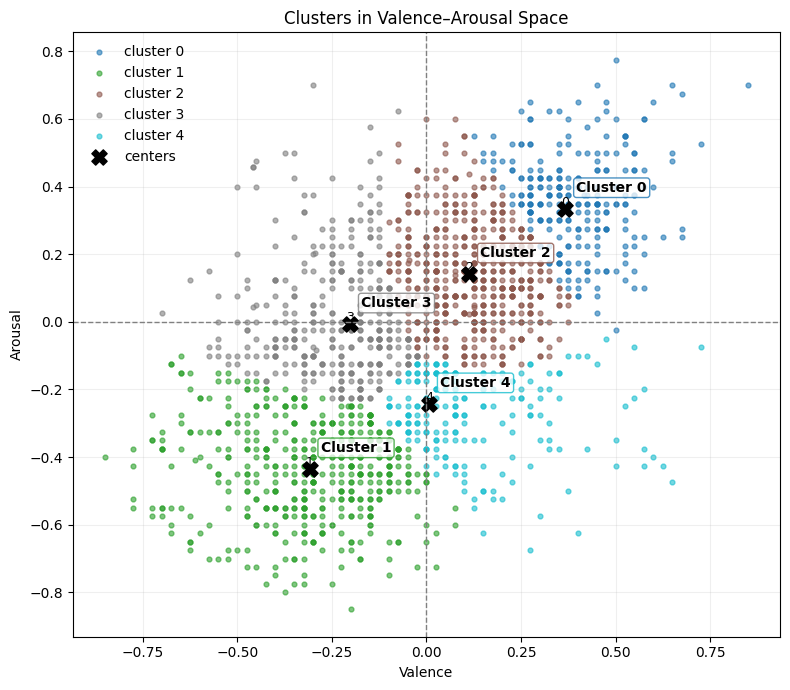

In [28]:
K = gm.n_components
colors = (
    plt.cm.tab10(np.linspace(0, 1, K))
    if K <= 10
    else plt.cm.nipy_spectral(np.linspace(0, 1, K))
)

plt.figure(figsize=(8, 7))
for k in range(K):
    mask = labels == k
    plt.scatter(
        X[mask, 0], X[mask, 1], s=12, alpha=0.6, color=colors[k], label=f"cluster {k}"
    )

# centers (in original space)
plt.scatter(
    centers_orig[:, 0],
    centers_orig[:, 1],
    c="black",
    s=120,
    marker="X",
    label="centers",
)

# add "Cluster k" annotations near each center
for k, (cx, cy) in enumerate(centers_orig):
    plt.annotate(
        f"Cluster {k}",
        xy=(cx, cy),
        xytext=(8, 10),  # offset to avoid overlapping the 'X'
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="black",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=colors[k], alpha=0.8),
    )

for i, (cx, cy) in enumerate(centers_orig):
    plt.text(cx, cy, str(i), color="black", fontsize=9, ha="center", va="bottom")

# quadrant lines
plt.axvline(0, color="gray", lw=1, ls="--")
plt.axhline(0, color="gray", lw=1, ls="--")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.title("Clusters in Valence–Arousal Space")
plt.legend(loc="best", frameon=False)
plt.grid(alpha=0.2)

# quadrant distribution (overall and per-cluster)
q1 = int(np.sum((X[:, 0] >= 0) & (X[:, 1] >= 0)))
q2 = int(np.sum((X[:, 0] < 0) & (X[:, 1] >= 0)))
q3 = int(np.sum((X[:, 0] < 0) & (X[:, 1] < 0)))
q4 = int(np.sum((X[:, 0] >= 0) & (X[:, 1] < 0)))
print(f"Quadrant counts (overall): Q1={q1}, Q2={q2}, Q3={q3}, Q4={q4}")
for k in range(K):
    Xm = X[labels == k]
    q1k = int(np.sum((Xm[:, 0] >= 0) & (Xm[:, 1] >= 0)))
    q2k = int(np.sum((Xm[:, 0] < 0) & (Xm[:, 1] >= 0)))
    q3k = int(np.sum((Xm[:, 0] < 0) & (Xm[:, 1] < 0)))
    q4k = int(np.sum((Xm[:, 0] >= 0) & (Xm[:, 1] < 0)))
    print(f"Cluster {k} quadrant counts: Q1={q1k}, Q2={q2k}, Q3={q3k}, Q4={q4k}")

plt.tight_layout()
plt.show()

The emotion landscape is not genre-pure: every cluster mixes many genres, and purity ≈0.2–0.25 across the board.

There are two distinct positive–energetic regions (k=0 mild, k=2 strong), and two negative–low-arousal regions (k=3 pronounced, k=1 milder/tenser). A near-neutral/low-arousal region (k=4) rounds out the five.

The metrics (Silhouette ~0.32, DB ~0.92) are consistent with real, moderately distinct structure in valence–arousal space; not perfectly separable (expected for affect data), but useful.

## Evaluate Clusters

**Silhouette score** 

+ Silhouette compares how close a point is to its own cluster vs. the nearest other cluster.   
+ It ranges from −1 to 1.   
+ Values > 0.5 suggest strong structure, ~0.25–0.5 suggest reasonable structure, and ≤ 0 indicate overlapping or wrong assignments.   
+ Our 0.3 indicates moderately separated clusters.

**Davies–Bouldin index**  

+ DB measures the average similarity between each cluster and its most similar neighbor; lower is better. 
+ Values < 1 generally indicate compact, well-separated clusters. 
+ Ours is 0.920 → healthy separation.

**Calinski–Harabasz index** 
  
+ CH is the ratio of between-cluster dispersion to within-cluster dispersion; higher is better. 
+ It tends to grow with clearer separation and more compact clusters. 
+ Because it’s unbounded, we compare it across candidate solutions rather than interpret it absolutely.

**Posterior entropy (soft assignment uncertainty)**  

+ Given the per-cluster posteriors for a point, entropy summarizes how confident the model is. 
+ Entropy is 0 for a crisp assignment (one posterior ≈1) and higher when probability mass is spread. 
+ Reporting mean entropy (and its distribution per cluster) helps identify borderline vs core points.

In [29]:
print(f"K={gm.n_components}, cov={gm.covariance_type}")
print(f"BIC={best_bic:.1f} | train_LL={train_ll:.3f} | test_LL={test_ll:.3f}")

print(
    f"Full data → silhouette={sil:.3f} | davies-bouldin={db:.3f} | calinski-harabasz={ch:.1f} | avg posterior entropy={entropy:.3f}"
)

print(f"Train       → silhouette={sil_tr:.3f} | DB={db_tr:.3f} | CH={ch_tr:.1f}")
print(
    f"Test        → silhouette={sil_te:.3f} | DB={db_te:.3f} | CH={ch_te:.1f} | avg posterior entropy={entropy_te:.3f}"
)


K=5, cov=diag
BIC=7608.4 | train_LL=-2.579 | test_LL=-2.626
Full data → silhouette=0.325 | davies-bouldin=0.899 | calinski-harabasz=1538.6 | avg posterior entropy=0.686
Train       → silhouette=0.329 | DB=0.897 | CH=1237.7
Test        → silhouette=0.302 | DB=0.920 | CH=300.8 | avg posterior entropy=0.691


In [30]:
print("converged:", gm.converged_, "| iters:", gm.n_iter_)
# check smallest eigenvalue across components (standardized space)


def min_eigvals(gm):
    if gm.covariance_type == "full":
        return min(np.linalg.eigvalsh(S).min() for S in gm.covariances_)
    elif gm.covariance_type == "diag":
        return float(np.min(gm.covariances_))
    else:  # 'tied' or 'spherical' if you ever use them
        return float(np.min(gm.covariances_))


print("min eigenvalue:", min_eigvals(gm))


converged: True | iters: 8
min eigenvalue: 0.2133584752332683


In [31]:
# # ---- 4) (Optional) Attach cluster labels back to a Polars frame ----
# # Use this for downstream retrieval or plotting.
# deam_with_clusters = df_pl.with_columns([
# pl.Series('cluster', labels),
# pl.Series('cluster_conf', proba.max(axis=1)),
# ])


# # ---- 5) Helper: match a new (valence, arousal) prediction to a cluster ----
# # Example: match_cluster(5.2, 4.1)


# def match_cluster(valence: float, arousal: float):
# x = np.array([[valence, arousal]])
# p = gm.predict_proba(scaler.transform(x)).ravel()
# k = int(np.argmax(p))
# return {'cluster': k, 'confidence': float(p[k])}